# FINAL

Check existing tensorflow and keras library version using the following command
```
!pip show tensorflow
!pip show keras
```

Upgrade tensorflow and keras library to latest version using the following command
```
!pip install --upgrade tensorflow
!pip install --upgrade keras
```

## Importing dependencies

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import logging
import sys
import contextlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from matplotlib import pyplot as plt
# for custom CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

## Loading dataset

In [2]:
data = pd.read_csv("DR_dataset_archive 3/trainLabels_cropped.csv")
print(data.value_counts().sum())
print(data['level'].unique())
print(data['level'].value_counts().unique())
data.head()

35108
[0 1 2 4 3]
[25802  5288  2438   872   708]


,Unnamed: 0,Unnamed: 0.1,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1


## Dropping unnecessary columns

In [3]:
data.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)
data.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Creating a balanced dataset

In [4]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Define your dataset
X = data['image']  # Your feature data
y = data['level']  # Your class labels

# Convert DataFrame or Series to a numpy array
X_array = X.values.reshape(-1,1)
y_array = y.values.reshape(-1,1)

# Count the number of datapoints for each class
class_counts = {0: 25802, 1: 5288, 2: 2438, 3: 872, 4: 708}

# Find the target number of datapoints
target_count = class_counts[3]

# # Undersample the majority classes
# undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys() if label != 4})
# X_resampled, y_resampled = undersampler.fit_resample(X_array, y_array)

# # Check the new class counts
# unique, counts = np.unique(y_resampled, return_counts=True)
# resampled_class_counts = dict(zip(unique, counts))
# print("Resampled class counts:", resampled_class_counts)

Not balancing the dataset as the accuracy is so less after undersampling

The drop in accuracy after undersampling is a common issue in machine learning, particularly in cases of class imbalance. 

**Reason**

Loss of Information: 

Undersampling reduces the number of instances from majority classes, which can lead to a loss of valuable information. If the majority classes contain important patterns that help the model generalize, removing them may degrade performance.

Insufficient Data: 

After undersampling, if the dataset becomes too small, the model might not have enough examples to learn from, especially for the minority classes. This can lead to overfitting on the limited examples available.

Class Distribution: 

The model might be overly biased towards the remaining classes after undersampling. If the dataset does not provide a balanced view of the problem, the model might struggle to learn the characteristics of the minority classes effectively.

Evaluation Metric: 

Accuracy might not be the best metric to evaluate your model in imbalanced datasets. It's often more informative to look at metrics such as precision, recall, F1-score, or AUC-ROC, as they provide better insights into model performance across different classes.

Model Complexity: 

Some models are more sensitive to class imbalance. If the model is too simple, it may not capture the complexities of the data after undersampling. Conversely, overly complex models might overfit to the smaller dataset.

In [5]:
X

0            10_left
1           10_right
2            13_left
3           13_right
4            15_left
            ...     
35103    44347_right
35104     44348_left
35105    44348_right
35106     44349_left
35107    44349_right
Name: image, Length: 35108, dtype: object

In [6]:
new_X = []
# print(len(X))
for i in X:
  new_X.append(i)

In [7]:
new_X

['10_left',
 '10_right',
 '13_left',
 '13_right',
 '15_left',
 '15_right',
 '16_left',
 '16_right',
 '17_left',
 '17_right',
 '19_left',
 '19_right',
 '20_left',
 '20_right',
 '21_left',
 '21_right',
 '22_left',
 '22_right',
 '23_left',
 '23_right',
 '25_left',
 '25_right',
 '30_left',
 '30_right',
 '31_left',
 '31_right',
 '33_left',
 '33_right',
 '36_left',
 '36_right',
 '40_left',
 '40_right',
 '41_left',
 '41_right',
 '42_left',
 '42_right',
 '46_left',
 '46_right',
 '47_left',
 '47_right',
 '49_left',
 '49_right',
 '51_left',
 '51_right',
 '52_left',
 '52_right',
 '54_left',
 '54_right',
 '56_left',
 '56_right',
 '57_left',
 '57_right',
 '58_left',
 '58_right',
 '59_left',
 '59_right',
 '60_left',
 '60_right',
 '62_left',
 '62_right',
 '64_left',
 '64_right',
 '65_left',
 '65_right',
 '66_left',
 '66_right',
 '67_left',
 '67_right',
 '70_left',
 '70_right',
 '72_left',
 '72_right',
 '73_left',
 '73_right',
 '74_left',
 '74_right',
 '75_left',
 '75_right',
 '78_left',
 '78_right',


In [8]:
y

0        0
1        0
2        0
3        0
4        1
        ..
35103    0
35104    0
35105    0
35106    0
35107    1
Name: level, Length: 35108, dtype: int64

In [9]:
print(len(new_X), len(y))

35108 35108


In [10]:
# Create a new dataframe with resampled data
resampled_data = {'image': new_X,
        'level': y}

balanced_data = pd.DataFrame(resampled_data)

# Display the first few rows of the new dataframe
balanced_data.sample(10)

,image,level
25025,31698_right,0
3581,4488_right,0
34686,43840_left,0
4042,5065_left,0
27731,35119_right,0
31670,40014_left,0
28596,36234_left,0
13867,17411_left,2
9897,12481_left,2
12669,15902_left,0


In [11]:
print(balanced_data.value_counts().sum())
print(balanced_data['level'].unique())
print(balanced_data['level'].value_counts().unique())

35108
[0 1 2 4 3]
[25802  5288  2438   872   708]


In [12]:
balanced_data['image'] = balanced_data['image']+'.jpeg'
balanced_data.head()

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


### Splitting data

In [13]:
train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [14]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

### Rescaling image data

Data augmentation
- The below configuration applies several transformations to the training images, making the model more robust by allowing it to learn from various augmented versions of the original data. 
- This process is called data augmentation and helps to prevent overfitting in case of limited data.

Why only training data is augmented?
- Data augmentation is used on the training set to simulate a larger and more diverse dataset, allowing the model to generalize better to new data. 
- For validation, the original, unaltered data is used to get an accurate measure of how the model performs on unseen data

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Rescales pixel values from [0, 255] to [0, 1].
    rotation_range=30,              # Randomly rotates images by up to 30 degrees.
    width_shift_range=0.2,          # Randomly shifts images horizontally by 20% of the width.
    height_shift_range=0.2,         # Randomly shifts images vertically by 20% of the height.
    shear_range=0.2,                # Applies random shearing transformations by up to 20%.
    zoom_range=0.2,                 # Randomly zooms in or out by up to 20%.
    horizontal_flip=True,           # Randomly flips images horizontally (left to right).
    fill_mode='nearest'             # Fills in pixels that are lost after transformations using the nearest pixel values.
)
val_datagen = ImageDataGenerator(rescale=1./255)    # Rescales pixel values from [0, 255] to [0, 1].

- The train_generator and val_generator are Keras generators that read image files from directories (as specified by the directory parameter), 
apply transformations (like resizing or data augmentation in the case of train_generator), 
and yield batches of images 
and their corresponding labels during model training and validation.
- The flow_from_dataframe method is used here because the dataset is organized with image paths stored in a dataframe (train and val), along with the corresponding labels.

In [16]:
# create image data generators 

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,                                   # The dataframe containing image filenames and labels.
    directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped',  # The directory where the images are stored.
    x_col='image',                                     # The column in the dataframe that contains the image filenames.
    y_col='level',                                     # The column in the dataframe that contains the corresponding labels.
    target_size=IMAGE_SIZE,                            # Resizes all images to the specified target size (e.g., 224x224).
    batch_size=BATCH_SIZE,                             # Number of images to be returned in each batch during training.
    class_mode='raw'                                   # Specifies that labels should be returned as they are (numerical form).
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,                                     # The dataframe containing validation image filenames and labels.
    directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped/',  # Validation images directory.
    x_col='image',                                     # Column in the dataframe with image filenames.
    y_col='level',                                     # Column in the dataframe with the corresponding labels.
    target_size=IMAGE_SIZE,                            # Resizes validation images to the specified target size.
    batch_size=BATCH_SIZE,                             # Number of images in each batch during validation.
    class_mode='raw'                                   # Labels are returned in raw numerical form.
)

Found 28086 validated image filenames.
Found 7022 validated image filenames.


## Loading MobileNetV2

- MobileNetV2
    - MobileNetV2 is a lightweight, efficient, and small CNN architecture developed by Google, designed for efficient performance on mobile and edge devices.
    - pre-trained deep learning model from the MobileNet family.
    - improved version that uses depthwise separable convolutions and an architecture optimized for low memory and high speed.

In [17]:
# loading a pre-trained MobileNetV2 model without the top layers (the classification head) 
# and preparing it to take input images of size 224x224x3 (height, width, and RGB channels)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

- weights='imagenet'
    - This specifies that the model should be loaded with weights pre-trained on the ImageNet dataset, which contains millions of labeled images across 1000 categories.
    - By using pre-trained weights, you can benefit from transfer learning, leveraging features the model learned during its training on the ImageNet dataset.

- 'include_top = False'
    - This means that the fully connected (dense) layers at the top of the model, which are specific to the ImageNet classification task, are excluded.
    - Instead, custom CNN layers are built on top of the MobileNetV2 model to adapt it for classifying retinal images for diabetic retinopathy.
    - MobileNetV2 without the top layers will output feature maps instead of final predictions, allowing to build a custom classifier on top of the base model.

In [18]:
# This gives you the feature maps extracted by the pre-trained MobileNetV2.
x = base_model.output   # x is the output of the MobileNetV2 base model

# Custom CNN layers 
x = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01), input_shape = (7,7))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fully connected layers
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

- Conv2D
    - adds a 2D convolutional layer with 512 filters, each of size 3x3
    - Activation: Uses ReLU activation function, which introduces non-linearity.
    - Padding='same': Ensures that the output feature maps have the same size as the input by padding the input if necessary.
    - kernel_regularizer=l2(0.01): This adds L2 regularization to the convolutional layer. Regularization helps reduce overfitting by penalizing large weights in the model, effectively adding a constraint that encourages the weights to be smaller.

- MaxPooling2D
    - A max-pooling layer reduces the spatial dimensions of the feature maps (height and width), 
    - which helps reduce computational complexity 
    - and also retains the most important information by taking the maximum value in a 2x2 region.

- GlobalAveragePooling2D
    - This reduces the dimensions of the data, preventing overfitting and decreasing computational cost while retaining important information.
    - reduces each feature map to a single value by computing the average of all values in the feature map. 
    - This results in a compact representation of the feature maps, effectively reducing the number of parameters compared to flattening.
    - This is useful to prevent overfitting while retaining essential information from the previous layers.

- Dense(1024, activation='relu', kernel_regularizer=l2(0.01))
    - Adds a fully connected (dense) layer with 1024 neurons and ReLU activation.
    - L2 regularization (0.01) is applied here to reduce overfitting by penalizing large weights.

- Dropout(0.2)
    - Dropout is a regularization technique that randomly "drops out" (sets to zero) 20% of the neurons in the fully connected layer during training. 
    - This prevents the model from becoming too dependent on any single neuron, reducing overfitting.

- Dense(NUM_CLASSES, activation='softmax')
    - This final dense layer has a number of neurons equal to the number of classes (NUM_CLASSES), with a softmax activation function.
    - Softmax: Converts the output into probabilities for each class, where the sum of all outputs will be 1. This is used for multi-class classification.

## Building the model

- building a custom model that uses MobileNetV2 as the feature extractor and adds your own custom layers on top to perform the final classification task. 
- The final model is composed of:
    - MobileNetV2's input layer.
    - All the layers of MobileNetV2, without the top layers because include_top=False is specified.
    - Your custom CNN, pooling, and fully connected layers, which further process the feature maps and perform the classification task.
    - This model will take an image as input and output a prediction for the class (different levels of Diabetic Retinopathy).

In [19]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
# GlobalAveragePooling2D is used here instead of Flatten because it compresses the feature maps efficiently 
# while still retaining the most important information

In [21]:
# GlobalAveragePooling2D
    # This layer operates on the output of convolutional layers by calculating the average of each feature map. 
    # It reduces each feature map to a single number by taking the average across all spatial dimensions (height and width), resulting in a vector of averages.
    # It effectively reduces the spatial dimensions (height and width) of the feature maps to 1, 
        # leaving only the depth (number of filters). 
    # For example, if your convolutional output is of shape (7, 7, 512), after GlobalAveragePooling2D, 
        # it becomes a single vector of shape (512,) by averaging the values across the 7x7 grid for each of the 512 channels.

# Flatten
    # Flatten converts a multi-dimensional tensor into a one-dimensional vector. 
    # For example, if the input is of shape (7, 7, 512), Flatten will reshape it into a vector of shape (7 * 7 * 512) = (25088,).
    # This would retain more information than GlobalAveragePooling2D but also result in a much larger vector, 
    # potentially leading to overfitting and increased computational cost.

# Why only GlobalAveragePooling2D is used
    # GlobalAveragePooling2D is used to significantly reduce the number of parameters by summarizing each feature map into a single value, 
        # thus avoiding overfitting while still capturing essential information. 
        # This is especially useful in models like MobileNetV2, which are designed for efficiency and
            # often paired with pooling instead of flattening to maintain compactness.
    # If you were to Flatten first, you would drastically increase the size of the vector, 
        # leading to a much larger and potentially over-parameterized model, 
        # which could slow down training and increase the risk of overfitting.

### Freezing the model
- The below loop sets the trainable attribute of all layers in the base_model (MobileNetV2) to False, which means
    - Freezing the layers
        - The weights of these layers will not be updated during training. 
        - This effectively "freezes" the feature extraction part of the model (i.e., MobileNetV2), allowing it to retain the knowledge it learned from pretraining on ImageNet.
    - Focus on custom layers
        - The model will only train the custom layers you've added on top of the base_model (such as the Conv2D layers, dense layers, etc.). 
        - This saves computation and avoids overfitting, especially when you have a smaller dataset, as MobileNetV2 has already learned useful features from its ImageNet training.

**Why freeze the base model?**
- Transfer Learning
    - Since MobileNetV2 was pretrained on a large dataset (ImageNet), it already has learned useful low-level and mid-level features (e.g., edges, textures, shapes). 
    - These features are often general enough to be applicable to other tasks, such as Diabetic Retinopathy classification.

- Faster convergence
    - Training only the new layers speeds up the process because fewer parameters need to be updated during training.

- Avoid overfitting
    - When dataset is small, it's better not to update the large number of parameters in MobileNetV2, as this could lead to overfitting.

In [22]:
# Freezing the model
for layer in base_model.layers:
    layer.trainable = False

### Model setup

- initial learning rate 
    - for the Adam optimizer
    - The learning rate controls how much to adjust the model's weights with respect to the loss gradient.
    - The learning rate directly influences how quickly or slowly the model learns. If it's too high, the model might not converge, and if it's too low, training could take too long or get stuck in local minima. Using a lower initial learning rate with the Adam optimizer is a common practice.

- Optimizer (Adam)
    - Adam is an adaptive learning rate optimizer that adjusts the learning rate based on past gradients
    - It’s generally more efficient and requires less tuning compared to other optimizers like SGD (Stochastic Gradient Descent)
    - passing learning_rate=initial_learning_rate to Adam so it starts with 0.001 as the learning rate.
    - Adam is popular because it adapts the learning rate for each parameter individually based on its gradients, making it well-suited for noisy datasets or complex optimization problems
- Loss function (sparse_categorical_crossentropy)
    - This loss function is used for multi-class classification where the labels are integers (not one-hot encoded).
    - It’s appropriate for classification problems where the output is a probability distribution (as given by the softmax activation in the final layer).
    - This loss function is efficient when dealing with integer labels, especially when your dataset has multiple classes
- Metrics (accuracy):
    - The model will track accuracy during training and validation. 
    - Accuracy is the proportion of correct predictions out of all predictions

In [23]:
initial_learning_rate = 0.001

In [24]:
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), 
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### learning rate scheduler
- reduces the learning rate if the validation loss (val_loss) doesn't improve for a specified number of epochs (patience)

- Prevent Overfitting: 
    - Reducing the learning rate when validation loss plateaus allows the model to refine its learning without overshooting or getting stuck in a local minimum.


- Dynamic Learning Rate
    - Instead of using a fixed learning rate throughout training, you adjust it based on how the model is performing. 
    - This helps to maintain steady progress during training and avoid stagnation when the model approaches a local optimum.

In [26]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

In [28]:
# history = model.fit(train_generator, validation_data=val_generator, epochs=10)

### initiate the training process for the model 

In [29]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stopping,lr_scheduler])

2024-10-28 23:53:11.011308: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
878/878 [==============================] - 7793s 9s/step - loss: 4.7966 - accuracy: 0.6691 - val_loss: 1.5850 - val_accuracy: 0.7412 - lr: 0.0010
Epoch 2/15
878/878 [==============================] - 3260s 4s/step - loss: 1.5228 - accuracy: 0.7158 - val_loss: 1.4439 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 3/15
878/878 [==============================] - 2456s 3s/step - loss: 1.3626 - accuracy: 0.7201 - val_loss: 1.1487 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 4/15
878/878 [==============================] - 5755s 7s/step - loss: 1.2658 - accuracy: 0.7230 - val_loss: 1.0901 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 5/15
878/878 [==============================] - 3984s 5s/step - loss: 1.1742 - accuracy: 0.7289 - val_loss: 1.0669 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 6/15
878/878 [==============================] - 896s 1s/step - loss: 1.0863 - accuracy: 0.7297 - val_loss: 1.0758 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 7/15
878/878 [==============================] - 845s 

In [32]:
model.save('drdCustomCNN_MobileNetV2_15epochs_NOUNDERSAMPLE.keras')
model.save('drdCustomCNN_MobileNetV2_15epochs_NOUNDERSAMPLE.weights.h5')
model.save('drdCustomCNN_MobileNetV2_15epochs_NOUNDERSAMPLE.h5')
# model.save('drdCustomCNN_MobileNetV2_50epochs.keras')

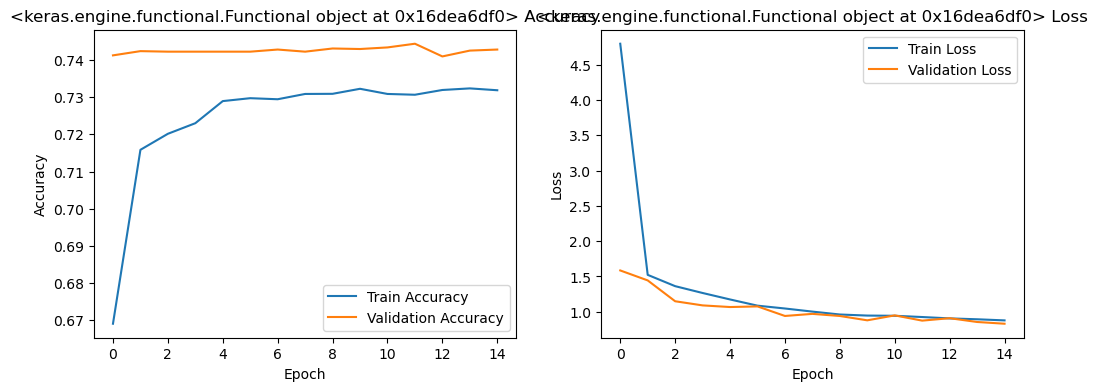

In [33]:
def plot_history(history, model_name):
    # Resumir la historia de la precisión
    plt.figure(figsize=(12, 4))

    # Gráfico de la precisión (accuracy)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Gráfico de la pérdida (loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Iterar sobre el diccionario para generar los gráficos para cada modelo
plot_history(history, model)

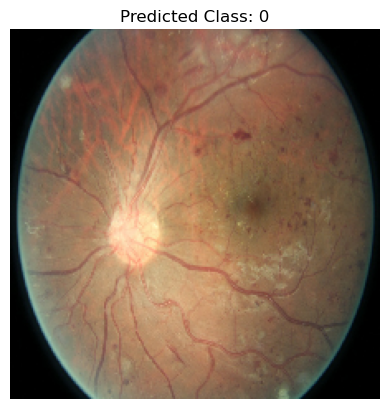

In [40]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
# img_path = 'combine_dataset/classifier_one_data/ODIR-5K/ODIR-5K/Training Images/6_right.jpg'  # Replace with your image path
img_path = 'DR_dataset_archive 3/resized_train_cropped/resized_train_cropped_1024/16_right.jpeg'  # Replace with your image path
target_size = (224, 224)  # Model's expected input size
img = image.load_img(img_path, target_size=target_size)  # Resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed

# Make predictions
prediction = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(prediction)  # For multi-class
# For binary classification, use:
# predicted_class = (prediction > 0.5).astype(int)

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


- MobileNet model prediction is not as accurate as Xception model